# Train HOTS model and run inference

In [17]:
from __future__ import print_function
import argparse
import os
import glob
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from event_Python import eventvision
from lib.noise_filter import remove_isolated_pixels
from lib.layer_operations import visualise_time_surface_for_event_stream, initialise_time_surface_prototypes, \
    generate_layer_outputs, train_layer, visualise_activations, generate_histogram
from lib.utils import euclidean_dist
from dataset import *
repr_map = {'eventFrame':get_eventFrame,
            'eventAccuFrame':get_eventAccuFrame,
            'timeSurface':get_timeSurface,
            'eventCount':get_eventCount}
width = 640
height = 480

绘制最终特征

In [18]:
def plot_event_data(event_data, width, height):
    # 找到所有不同的极性值
    polarities = set(event.p for event in event_data)
    num_polarities = len(polarities)

    # 创建一个颜色列表，每种极性一个颜色
    colors = plt.cm.get_cmap('tab20', num_polarities).colors  # 使用tab20颜色映射，最多支持20种颜色
    cmap = ListedColormap(colors)

    image = np.zeros((height, width), dtype=int)

    events_by_polarity = {}
    for event in event_data:
        if event.p not in events_by_polarity:
            events_by_polarity[event.p] = []
        events_by_polarity[event.p].append((event.x, event.y))

    # 为每种极性分配一个颜色索引
    polarity_to_color_index = {p: i for i, p in enumerate(polarities)}

    for polarity, events in events_by_polarity.items():
        for x, y in events:
            image[y, x] = polarity_to_color_index[polarity]  # 使用颜色索引

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap, interpolation='nearest')
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()  # 翻转y轴，使其与图像坐标系一致
    plt.title('Event Data Feature Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def event_convert(event, width, height):
    ev = eventvision.Events(event.shape[0], width, height)
    # 提取时间戳并减去最小值
    timestamps = (event[:, 2] * 10000).astype(np.int64)
    min_timestamp = timestamps.min()
    normalized_timestamps = (timestamps - min_timestamp).astype(np.int32)
    # 赋值给 ev.data
    ev.data.x = event[:, 0]
    ev.data.y = event[:, 1]
    ev.data.ts = normalized_timestamps  # 使用归一化后的时间戳
    ev.data.p = event[:, 3]
    # 设置宽度和高度
    ev.width = width
    ev.height = height

    return ev

##  Configure network parameters 

In [19]:
N_1 = 2
tau_1 = 2000.
r_1 = 15

K_N = 2
K_tau = 2
K_r = 2

N_2 = N_1 * K_N
tau_2 = tau_1 * K_tau
r_2 = r_1 * K_r

N_3 = N_2 * K_N
tau_3 = tau_2 * K_tau
r_3 = r_2 * K_r

## Read in event data files

In [20]:
data_directory = "./datasets/test"
repr = ['timeSurface']
dataset = THU_EACT_50_CHL(datafile=data_directory, eval=True, augmentation=False, repr=repr)

index_to_test = 5                                           # 选取的样本编号
ev = dataset.__getitem__(index_to_test, True, False)        # 获取数据
ev = event_convert(ev, width, height)                       # 转为event

print("单个事件流数据形状:", ev.data.shape)
print("数据集长度", len(dataset))

input_files_all = []                # 所有事件流

for i in range(1):                 # 取若干事件流训练
    input_files_all.extend([dataset.__getitem__(index_to_test, True)])

# 初始化事件数据列表
event_data = []
event_data_filt = []

# 遍历所有事件流合并为长事件流（每个文件是一段事件流）
for ev_data in input_files_all:
    # 读取事件数据
    ev_data = event_convert(ev_data, width, height).data
    # ev_data = eventvision.read_dataset(f).data
    # 去除孤立像素
    ev_data_filt = remove_isolated_pixels(ev_data, eps=5, min_samples=10)[0]
    # 确保事件流的时间戳是单调递增的
    if len(event_data) > 0:
        ts_start_0 = event_data[-1].ts  # 获取上一个事件的时间戳

        for i in range(len(ev_data)):
            ev_data[i].ts += ts_start_0  # 更新当前事件的时间戳

    if len(event_data_filt) > 0:
        ts_start_1 = event_data_filt[-1].ts  # 获取上一个过滤后事件的时间戳

        for i in range(len(ev_data_filt)):
            ev_data_filt[i].ts += ts_start_1  # 更新当前过滤后事件的时间戳

    # 将当前文件的事件数据添加到总事件数据列表中
    event_data.extend(ev_data)
    event_data_filt.extend(ev_data_filt)

    print('事件流长度:', len(ev_data), len(ev_data_filt))

单个事件流数据形状: (1268179,)
数据集长度 13
事件流长度: 1268179 1160260


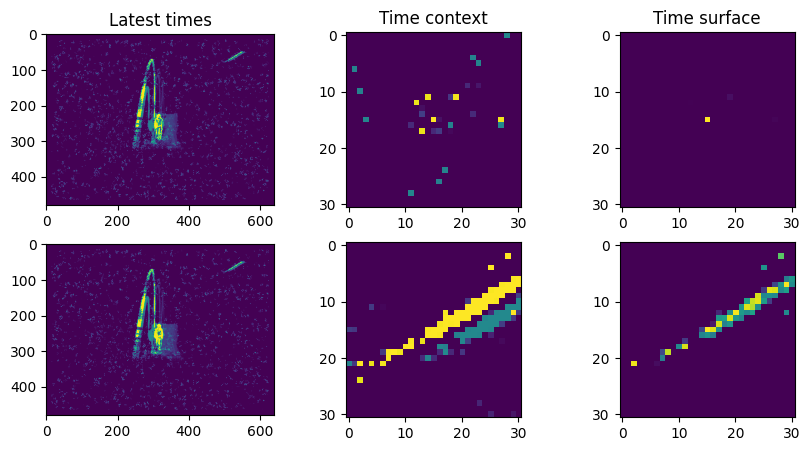

In [21]:
# 绘制单个事件序列的时间曲面
visualise_time_surface_for_event_stream(N_1, tau_1, r_1, ev.width, ev.height, ev.data)

## Train time surface prototypes for layer 1

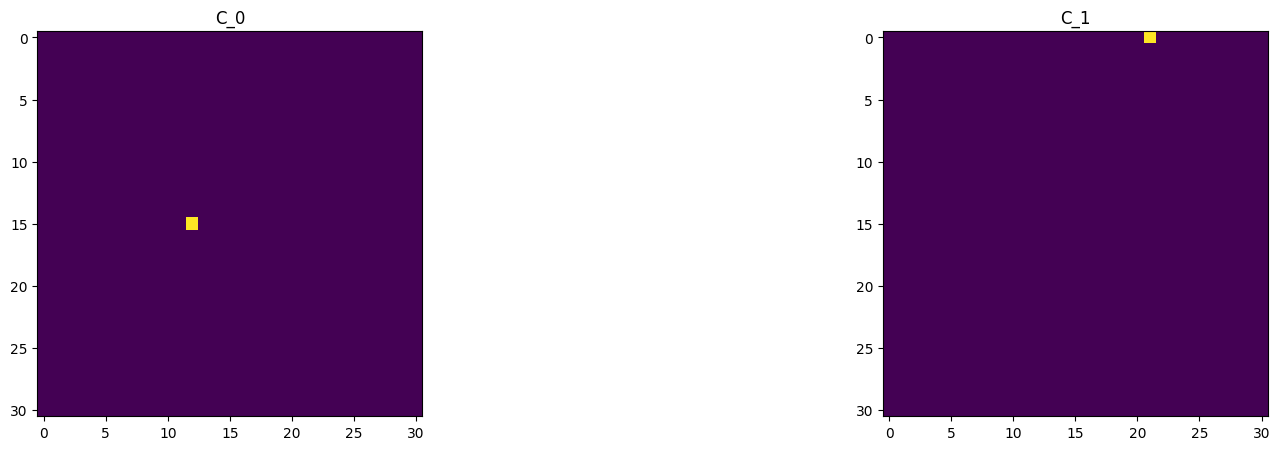

In [22]:
C_1 = initialise_time_surface_prototypes(N_1, tau_1, r_1, ev.width, ev.height, event_data_filt, plot=True)

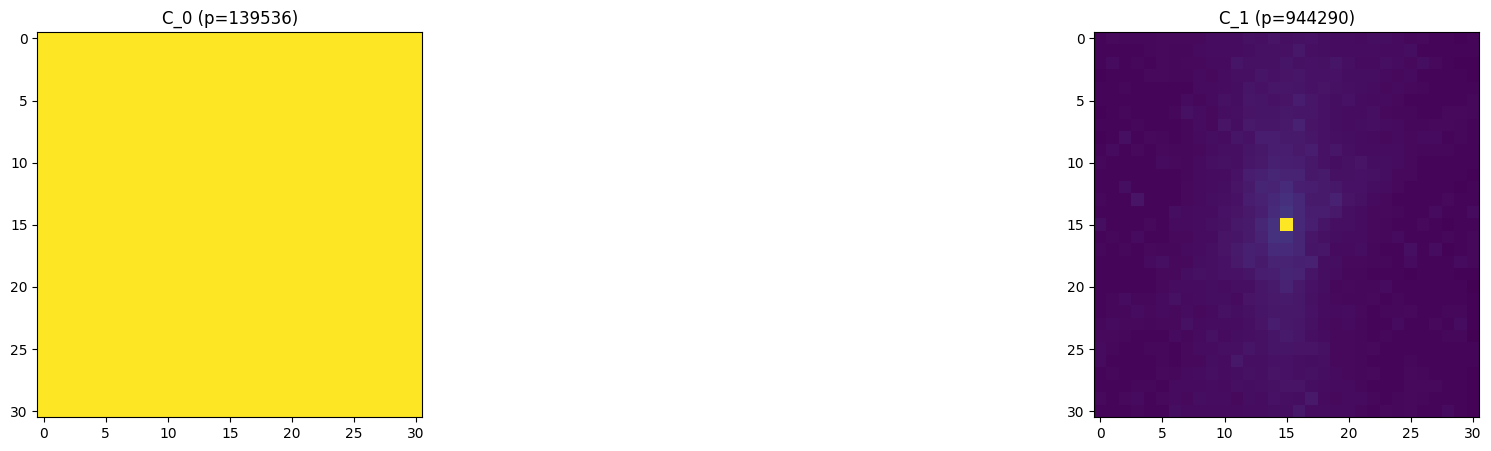

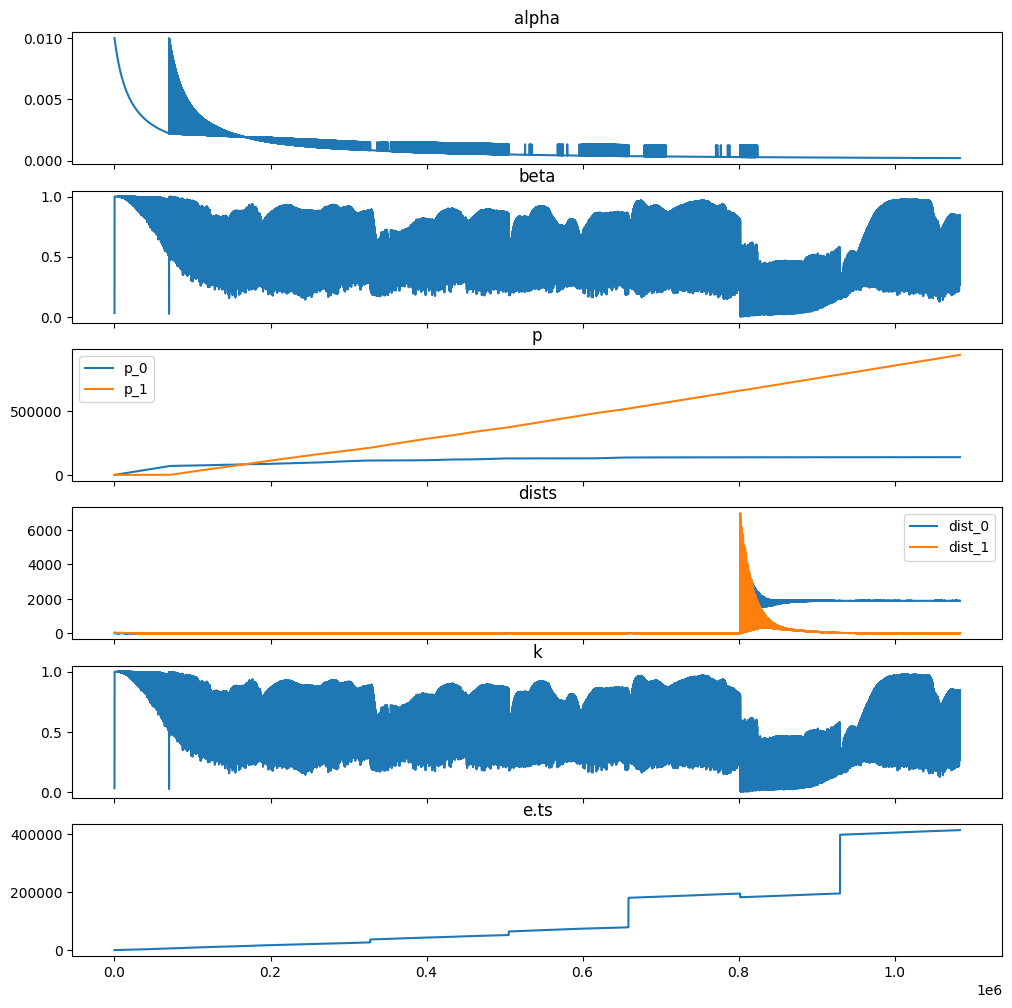

In [23]:
train_layer(C_1, N_1, tau_1, r_1, ev.width, ev.height, event_data_filt, num_polarities=2, layer_number=1, plot=True)

## Train time surface prototypes for layer 2

In [24]:
# generate event data at output of layer 1 (using the trained features)

event_data_2 = generate_layer_outputs(num_polarities=2, features=C_1, tau=tau_1, r=r_1, width=ev.width,
                                      height=ev.height, events=event_data_filt)

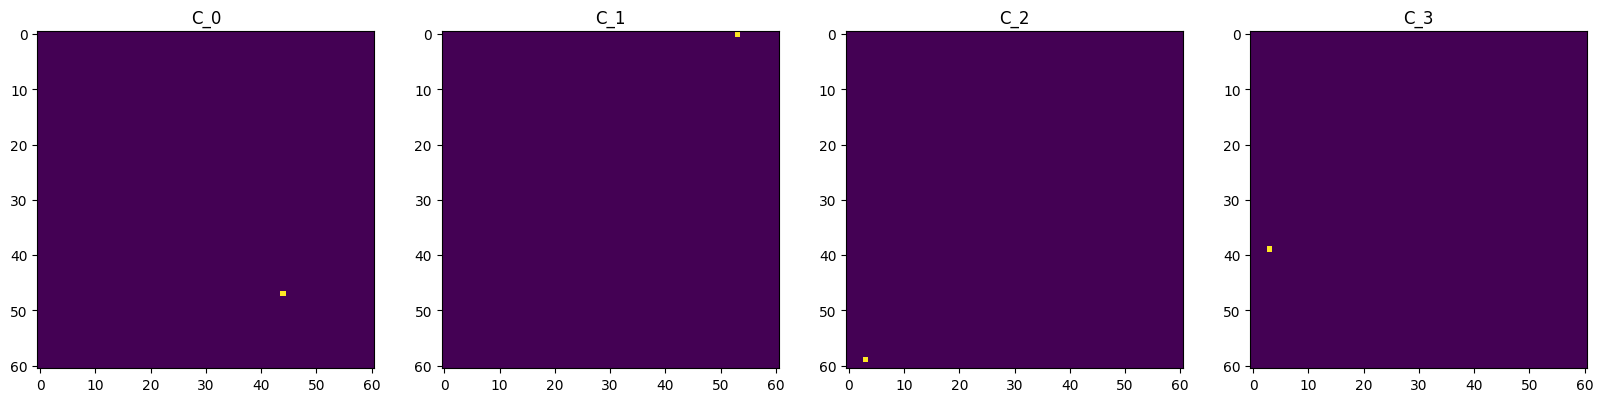

In [25]:
C_2 = initialise_time_surface_prototypes(N_2, tau_2, r_2, ev.width, ev.height, event_data_2, plot=True)

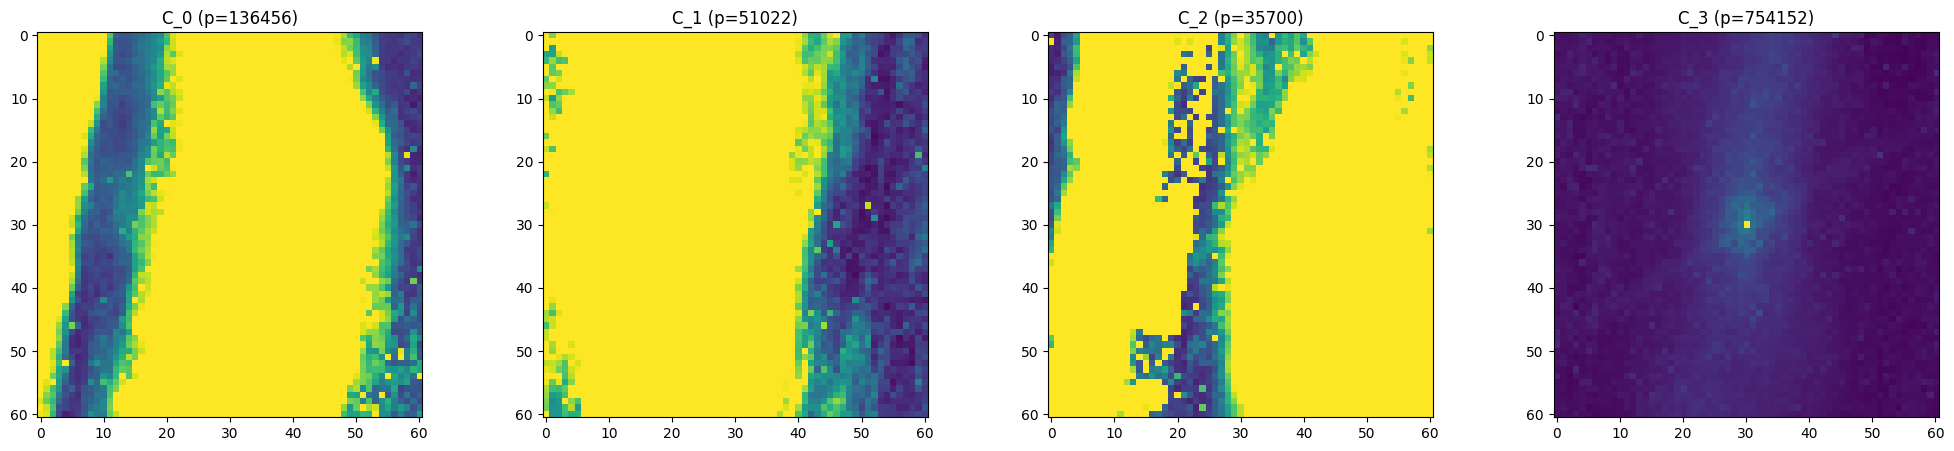

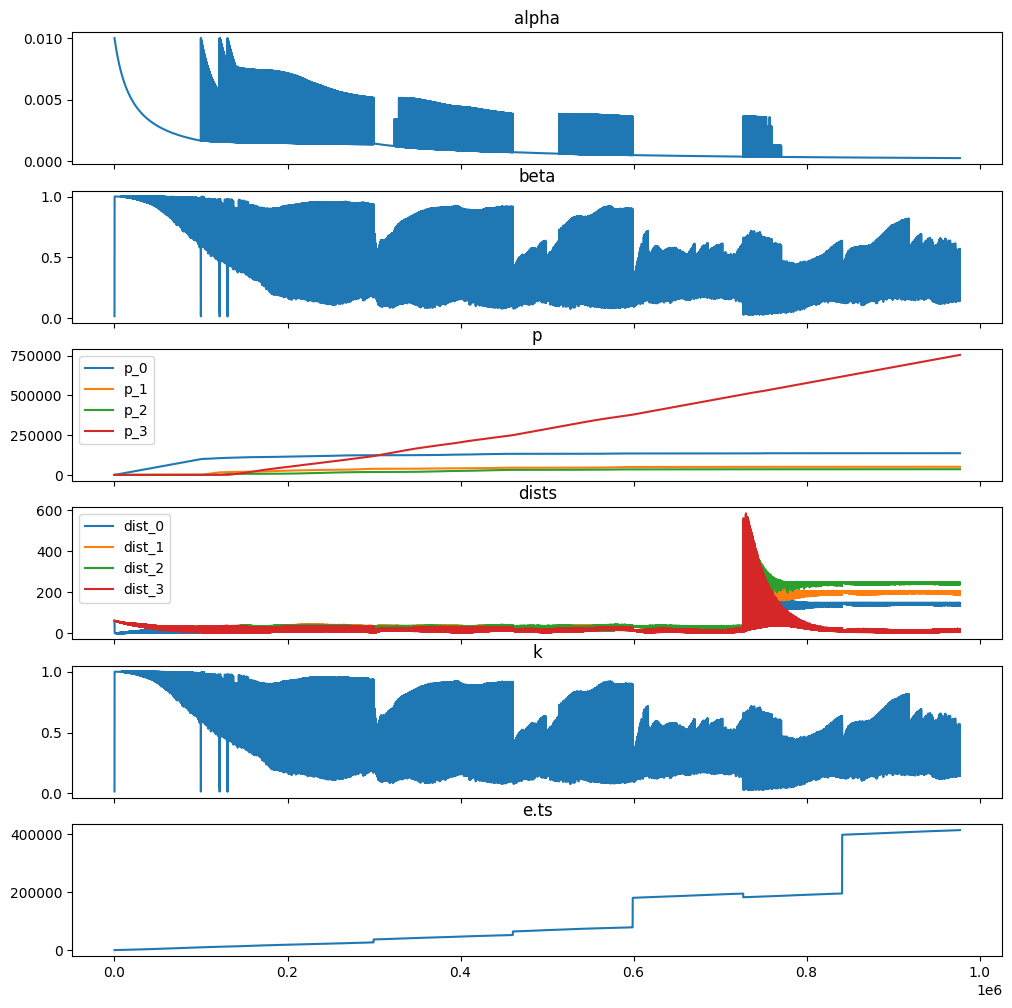

In [26]:
train_layer(C_2, N_2, tau_2, r_2, ev.width, ev.height, event_data_2, num_polarities=N_1, layer_number=2, plot=True)

## Train time surface prototypes for layer 3

In [27]:
# generate event data at output of layer 1 (using the trained features)

event_data_3 = generate_layer_outputs(num_polarities=N_1, features=C_2, tau=tau_2, r=r_2, width=ev.width,
                                      height=ev.height, events=event_data_2)

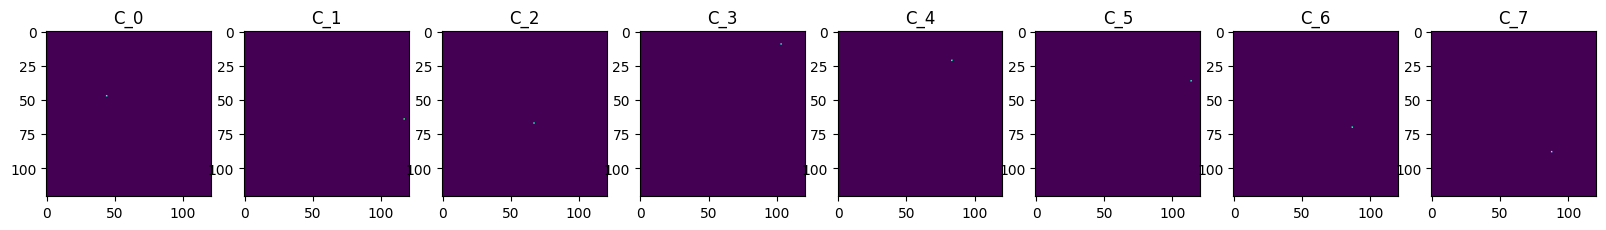

In [28]:
C_3 = initialise_time_surface_prototypes(N_3, tau_3, r_3, ev.width, ev.height, event_data_3, plot=True)

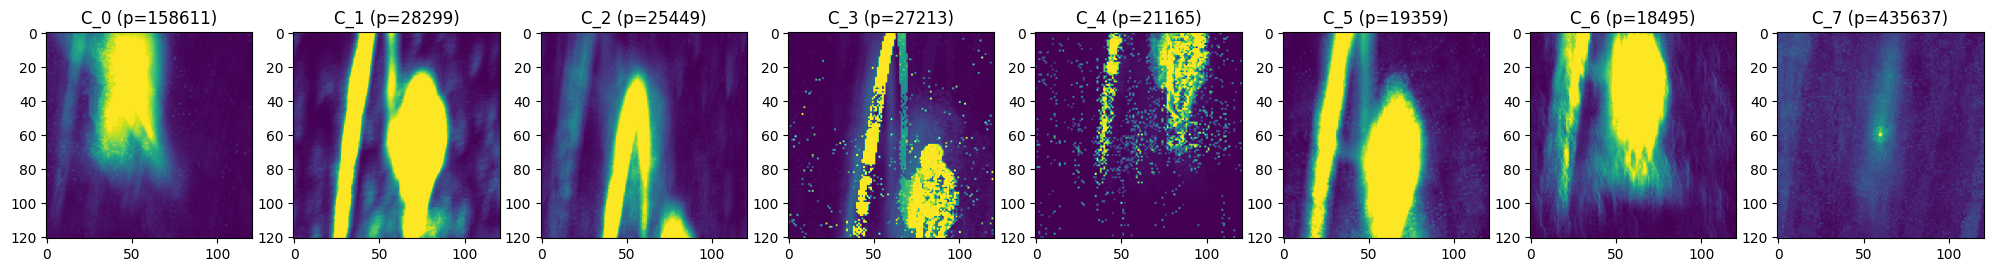

d:\python3.9\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


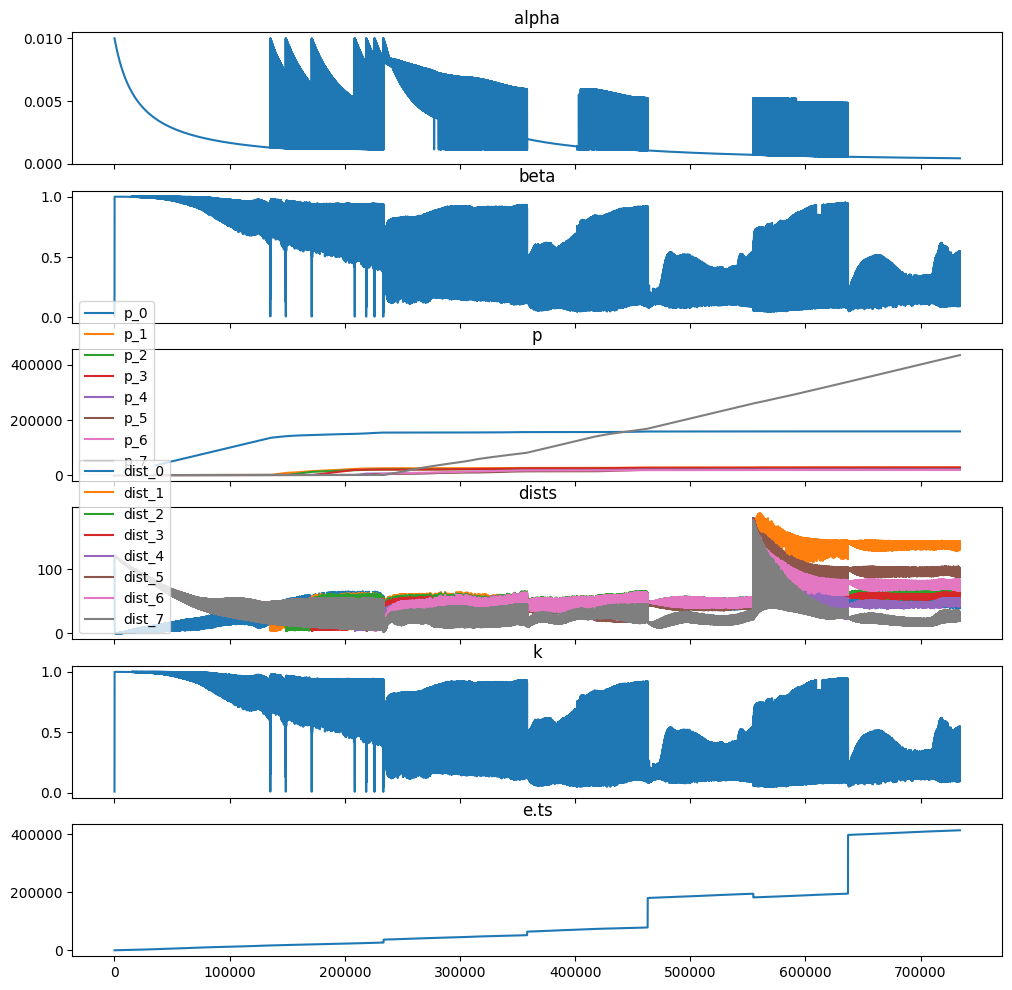

In [29]:
train_layer(C_3, N_3, tau_3, r_3, ev.width, ev.height, event_data_3, num_polarities=N_2, layer_number=3, plot=True)

## Plot activations of layer 1

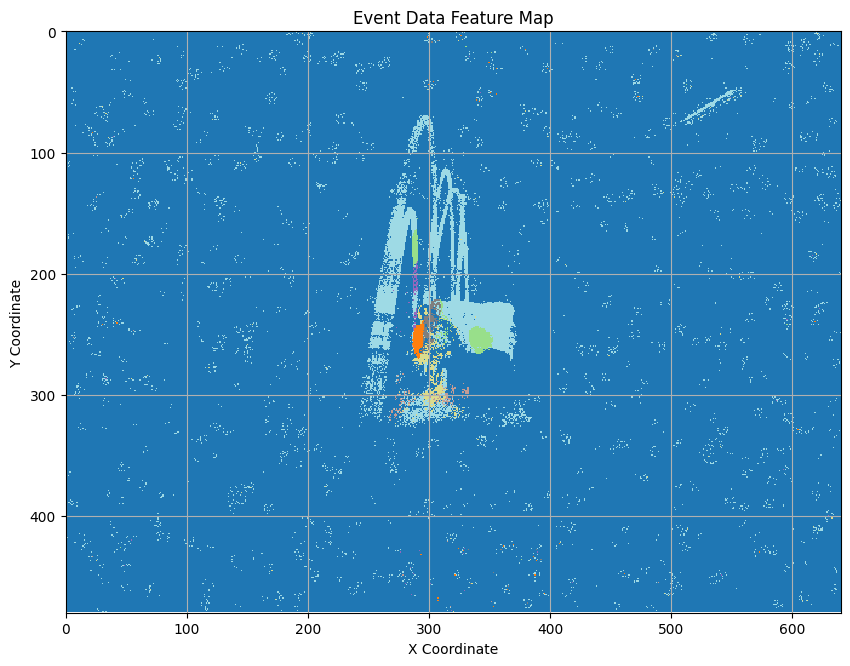

In [30]:
ev.data = remove_isolated_pixels(ev.data, eps=5, min_samples=20)[0]
ev2 = generate_layer_outputs(num_polarities=2, features=C_1, tau=tau_1, r=r_1, width=ev.width,
                                      height=ev.height, events=ev.data)
ev3 = generate_layer_outputs(num_polarities=N_1, features=C_2, tau=tau_2, r=r_2, width=ev.width,
                                      height=ev.height, events=ev2)
ev4 = generate_layer_outputs(num_polarities=N_2, features=C_3, tau=tau_3, r=r_3, width=ev.width,
                                      height=ev.height, events=ev3)
plot_event_data(ev4, ev.width, ev.height)

In [15]:
visualise_activations(12, ev.width, ev.height, ev4)

IndexError: list index out of range

## Generate histograms from output of last layer

* Generate a histogram from a single sample from each digit class (from the training event data).
* These histograms will be compared to when doing inference on test data to determine which digit the event stream corresponds to.

In [ ]:
input_folders_training_hist = [
    'datasets/mnist/Train/0',
    'datasets/mnist/Train/1',
    'datasets/mnist/Train/2',
    'datasets/mnist/Train/3',
    'datasets/mnist/Train/4',
    'datasets/mnist/Train/5',
    'datasets/mnist/Train/6',
    'datasets/mnist/Train/7',
    'datasets/mnist/Train/8',
    'datasets/mnist/Train/9']

hist_training_data = []

for folder in input_folders_training_hist:
    input_file = sorted(glob.glob(os.path.join(folder, '*.bin')))[0]
    
    hist_data = generate_histogram(input_file, C_1, C_2, C_3, N_1, N_2, N_3, r_1, r_2, r_3, tau_1, tau_2, tau_3, True)
    
    plt.subplots()
    plt.bar(range(N_3), hist_data['histogram'])
    plt.title('Label: {}'.format(hist_data['label']))
    
    hist_training_data.append(hist_data)
    
plt.show()

### Compare histograms from same class

* Generate a set of histograms for several samples from each digit class in the test dataset.
* These will be compared to the histograms on the training data to decide which class they belong to.

In [ ]:
root_test_folder = 'datasets/mnist/Test/'

test_histograms = []

for digit in range(10):
    # for each digit, feed the events through each layer of the network and calculate a histogram from the output of the last layer
    
    print('Generating histograms for digit', digit)
    
    folder = os.path.join(root_test_folder, str(digit))
    input_files = sorted(glob.glob(os.path.join(folder, '*.bin')))[:10]
    
    hist_data_digit = []

    for input_file in input_files:
        hist_data = generate_histogram(input_file, C_1, C_2, C_3, N_1, N_2, N_3, r_1, r_2, r_3, tau_1, tau_2, tau_3, True)
        hist_data_digit.append(hist_data)
        
    test_histograms.append(hist_data_digit)

In [ ]:
# plot a few of the histograms from a class

digit_to_plot = 0

for hist_data in test_histograms[digit_to_plot][:5]:
    plt.figure()
    plt.bar(range(N_3), hist_data['histogram'])
    plt.title('Label: {}'.format(hist_data['label']))

    plt.show()

### Plot confusion matrix

In [ ]:
# calculate which training histogram is closest to each test digit's histogram

y_true = []
y_pred = []
    
for test_digit in range(10):
    print('Digit', test_digit)
    for hist_data in test_histograms[test_digit]:
        dists = []

        for training_digit in range(10):
            dist = euclidean_dist(hist_data['histogram'], hist_training_data[training_digit]['histogram'])
            dists.append(dist)

        nearest_label = np.argmin(dists)
        y_true.append(test_digit)
        y_pred.append(nearest_label)

        print('actual label: {}, predicted label: {}'.format(test_digit, nearest_label))
        

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cnf_matrix)
plt.title('Confusion matrix')
plt.show()

cnf_matrix